In [23]:
import pandas as pd

file_path = 'data/focus_test.txt'
# Read the data while skipping the comment lines starting with '%'
df = pd.read_csv(file_path, comment='%')

df.head()

,Sample Index,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,Accel Channel 0,Accel Channel 1,Accel Channel 2,Other,Other.1,Other.2,Other.3,Other.4,Timestamp,Marker Channel,Timestamp (Formatted)
0,0.0,-128.089704,-66.787133,-63.578299,-71.966895,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.740590e+09,0.0,2025-02-26 11:13:54.013
1,1.0,-128.160762,-53.723663,-46.068088,-48.211050,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.740590e+09,0.0,2025-02-26 11:13:54.015
2,1.0,-130.068111,-60.268488,-42.907872,-57.500962,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.740590e+09,0.0,2025-02-26 11:13:54.015
3,2.0,-132.315790,-69.588318,-32.159400,-51.079554,-0.032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.740590e+09,0.0,2025-02-26 11:13:54.045
4,2.0,-128.931181,-59.277414,-26.508411,-41.995337,-0.032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.740590e+09,0.0,2025-02-26 11:13:54.045


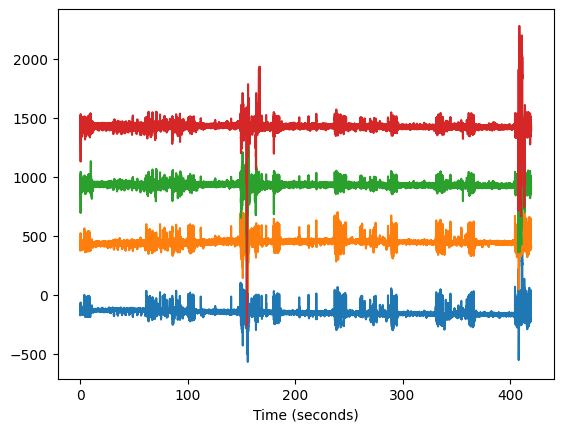

In [24]:
import matplotlib.pyplot as plt
import numpy as np

sampling_frequency = 200  

time = np.arange(0, len(df[' EXG Channel 1']) / sampling_frequency, 1 / sampling_frequency)
df['time'] = time

# Plot the data
plt.plot(df['time'], df[' EXG Channel 0'],label='Channel 1')
plt.plot(df['time'], df[' EXG Channel 1']+500,label='Channel 2')
plt.plot(df['time'], df[' EXG Channel 2']+1000,label='Channel 3')
plt.plot(df['time'], df[' EXG Channel 3']+1500,label='Channel 4')
plt.xlabel('Time (seconds)')  
plt.show()

In [25]:
from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from brainflow.data_filter import DataFilter, WindowOperations, DetrendOperations, NoiseTypes, WaveletTypes
from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels
from brainflow.data_filter import DataFilter
from brainflow.ml_model import MLModel, BrainFlowMetrics, BrainFlowClassifiers, BrainFlowModelParams

In [26]:
from scipy.signal import welch

In [27]:
fs = 200  # Sampling rate in Hz
freq_bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 50)}

def compute_band_power(data, fs, bands):
    f, psd = welch(data, fs=fs, nperseg=fs*2)  # Compute PSD using Welch’s method
    band_power = []
    for band, (low, high) in bands.items():
        idx = np.logical_and(f >= low, f < high)  # Find indices for the band
        band_power.append(np.mean(psd[idx]))  # Average power in the band
    return band_power

results = []
window_size = 2  # Window size in seconds
for start_time in np.arange(0, df['time'].max(), window_size):
    end_time = start_time + window_size
    window_data = df[(df['time'] >= start_time) & (df['time'] < end_time)]

    result = compute_band_power(data=window_data[' EXG Channel 0'],fs=fs,bands=freq_bands)
    results.append(result)

/Users/gregglickert/miniconda3/envs/neuron/lib/python3.10/site-packages/scipy-1.15.2-py3.10-macosx-10.13-x86_64.egg/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 400 is greater than input length  = 318, using nperseg = 318
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


In [28]:

mindfulness_list = []
restfulness_list = []
for i in range(len(results)):
    feature_vector = np.array(results[i])
    mindfulness_params = BrainFlowModelParams(BrainFlowMetrics.MINDFULNESS.value,
                                            BrainFlowClassifiers.DEFAULT_CLASSIFIER.value)
    # mindfulness is the focus metric 
    mindfulness = MLModel(mindfulness_params)
    mindfulness.prepare()
    mindfulness_list.append(mindfulness.predict(feature_vector))
    print('Mindfulness: %s' % str(mindfulness.predict(feature_vector)))
    mindfulness.release()

    # restfulness is the relaxation metric 
    restfulness_params = BrainFlowModelParams(BrainFlowMetrics.RESTFULNESS.value,
                                                BrainFlowClassifiers.DEFAULT_CLASSIFIER.value)
    restfulness = MLModel(restfulness_params)
    restfulness.prepare()
    restfulness_list.append(restfulness.predict(feature_vector))
    print('Restfulness: %s' % str(restfulness.predict(feature_vector)))
    restfulness.release()

Mindfulness: [2.17528393e-104]
Restfulness: [1.]
Mindfulness: [2.70172614e-08]
Restfulness: [0.99999997]
Mindfulness: [1.47141638e-58]
Restfulness: [1.]
Mindfulness: [5.79981526e-244]
Restfulness: [1.]
Mindfulness: [4.93605816e-85]
Restfulness: [1.]
Mindfulness: [5.25176726e-23]
Restfulness: [1.]
Mindfulness: [0.95158265]
Restfulness: [0.04841735]
Mindfulness: [0.99581606]
Restfulness: [0.00418394]
Mindfulness: [7.04643203e-05]
Restfulness: [0.99992954]
Mindfulness: [0.00129918]
Restfulness: [0.99870082]
Mindfulness: [0.99036234]
Restfulness: [0.00963766]
Mindfulness: [0.48285745]
Restfulness: [0.51714255]
Mindfulness: [0.0246246]
Restfulness: [0.9753754]
Mindfulness: [0.00145351]
Restfulness: [0.99854649]
Mindfulness: [0.00391934]
Restfulness: [0.99608066]
Mindfulness: [2.68490971e-22]
Restfulness: [1.]
Mindfulness: [0.99870254]
Restfulness: [0.00129746]
Mindfulness: [3.88959251e-23]
Restfulness: [1.]
Mindfulness: [0.02276511]
Restfulness: [0.97723489]
Mindfulness: [2.83546909e-28]
Re

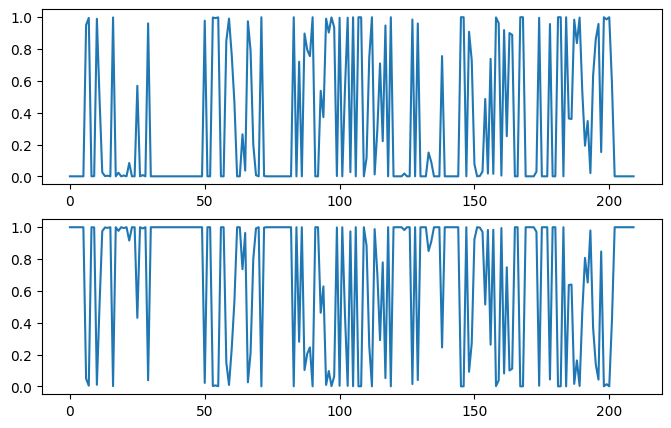

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))
axes = axes.ravel()

axes[0].plot(mindfulness_list)
axes[1].plot(restfulness_list)

plt.show()